In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/jhernandez/Work/')
sys.path.append('/home/jhernandez/Work/python_tools//')
from defaults import *
import os
import myio as io
from tools import select_experiments, set_font_size


#### Drifters files

In [2]:
files_drifters = glob('/home/jhernandez/Escritorio/Drifters/10_2014/files/*')
files_drifters.sort()

### Get HFR DIVAnd fields

In [3]:
file_diva = '/home/jhernandez/Work/data/SDC_IBIZACHANNEL_HFRadar_DP1.nc'
ds_hfr = xr.open_dataset(file_diva)

#### Experiments List

In [16]:
experiment_list = {'CR': ['HFR_NOASSIM_Oct2014', 'black', 'CR'], 
            'GNR': ['HFR_generic_nonudging_Oct2014_v2', 'dodgerblue', 'GNR'],
            'GNR-N': ['HFR_generic_nudging_Oct2014_v2', 'darkblue', 'GNR-N'],
            'Tot': ['HFR_totals_nonudging_Oct2014', 'olivedrab', 'TOT'],
            'Tot-N': ['HFR_totals_nudging_Oct2014', 'darkgreen', 'TOT-N'],
            'R-Raw': ['HFR_radials_raw_nonudging_Oct2014', 'salmon', 'RAD'],     
            'R-Raw-N': ['HFR_radials_raw_nudging_Oct2014', 'darkred', 'RAD-N'],     
            'R-In': ['HFR_radials_inside_nonudging_Oct2014', 'gold', 'R-In'],
            'R-In-N': ['HFR_radials_inside_nudging_Oct2014', 'goldenrod', 'R-In-N'],
            'R-Rep': ['HFR_radials_rep_nonudging_Oct2014', 'darkgrey', 'R-Rep'],
            'R-Rep-N': ['HFR_radials_rep_nudging_Oct2014', 'grey', 'R-Rep-N'],
            'DIVA': ['DIVAnd-fields_v2', 'fuchsia', 'DIVAnd'],
            'DIVA_Per': ['DIVAnd-fields_persistency', 'violet', 'DIVA-Per'],
            'DIVA_mean': ['DIVAnd-fields_daily-means', 'purple', 'DIVA-Mean']
            
           }



In [5]:
def clean_drifter_data(ds):

    #ds = ds.sel(time=slice('20141001','20141012'))
    ds = ds.where((ds.QC_LON==1) & (ds.QC_LAT==1) )

    d = np.diff(ds.LON)
    spikes = np.argwhere(d>0.2)
    spikes = [k[0]+1 for k in spikes]

    dlon = np.abs( np.diff(ds.LON) )
    dlat = np.abs( np.diff(ds.LAT) )

    sp_lon = np.argwhere(dlon>0.2) #| np.argwhere(dlat>0.2)
    sp_lon = [k[0]+1 for k in sp_lon]
    sp_lat = np.argwhere(dlat>0.2)
    sp_lat = [k[0]+1 for k in sp_lat]
    sp = sp_lon + sp_lat

    if len(sp)>0:
        ds.LON[sp] = np.nan
        ds.LAT[sp] = np.nan

        ds = ds.LON.dropna(dim='time')
        ds = ds.LAT.dropna(dim='time')
    
    return ds

#### Compute Lagrangian Metrics

In [6]:
import seawater as sw

# Drifter files
drifter_files = glob('/home/jhernandez/Escritorio/Drifters/10_2014/files/*nc')
drifter_files.sort()

#experiment_list = ['DIVAnd-fields', 'HFR_radials_raw_Oct2014']#, 'HFR_radial_nonudging_Oct2014_v15', 'HFR_radial_nonudging_Oct2014_v16', 'HFR_radial_nonudging_Oct2014_v17']

dist_mean = {}
dl_cm = {}
dist_all = {}

ndays = 8
ndrif = 13
nt = 121  #ds0.time.shape[1]

# Initialize for inicial position of drifter
lon0 = np.empty((ndrif, ndays)) #* np.nan
lat0 = np.empty((ndrif, ndays)) #* np.nan


## Set limits of DIVA field  --- DISTANCE will only be calculated whithin this area
lonmax_hfr = ds_hfr.lon.max().values
lonmin_hfr = ds_hfr.lon.min().values
latmax_hfr = ds_hfr.lat.max().values
latmin_hfr = ds_hfr.lat.min().values

for exp in experiment_list:

    # Distance travelled by dritfer every hour
    dl_drif = np.empty((ndays, nt-1, ndrif))

    print(exp)

    # Dates
    date_ini = datetime(2014,10,1)

    # Initialize distance matrix
    dist_mean[exp] = np.empty((nt, ndays))
    dl_cm[exp] = np.empty((ndays, nt-1, ndrif))
    dist_all[exp] = np.empty((ndays, nt, ndrif))

    for nday in range(ndays):

        date_end = date_ini + timedelta(days=5)

        strdate = date_ini.strftime('%Y%m%d')
        strdate_end = date_end.strftime('%Y%m%d')
        #print(strdate)

        # Path to virtual particle file
        #folder = F"/home/jhernandez/Work/trajectories/trajectories_HFR_DA/{experiment_list[exp][0]}/"
        folder = F"/LOCALDATA/HFR_DA/trajectories_HFR_DA/{experiment_list[exp][0]}/"
        file_virtual = F"{folder}/wmop_advection_{strdate}_{strdate_end}.nc"

        # Load Virtual particles for selected date
        ds = xr.open_dataset(file_virtual)

        dist_cm = np.empty((nt, ndrif))

        # Time of virtual particle simulations
        tp = ds.time.values
        tp = pd.to_datetime( np.unique(tp) )
        tp = tp[tp.notnull()]  # extract NaT values - (when ErrorBound)

        #ndrif0 = min(ds.lon[0::1000,0].shape[0], ndrif)
        lon0[:,nday] = ds.lon[0::1000,0][0:ndrif]
        lat0[:,nday] = ds.lat[0::1000,0][0:ndrif]
        
        # Loop in drifters
        for ii in range(ndrif):

            # Extract lon, lat and time for corresponding drifter
            lonp = ds.lon[ii*1000:(ii+1)*1000,:].values
            latp = ds.lat[ii*1000:(ii+1)*1000,:].values

            #i_out = (lonp > lonmin_hfr) & (lonp < lonmax_hfr) & (latp > latmin_hfr) & (latp < latmax_hfr)
            #lonp[~i_out] = np.nan
            #latp[~i_out] = np.nan

            # Load drifter data
            ds_drif = xr.open_dataset( drifter_files[ii] )
            ds_drif = clean_drifter_data(ds_drif)

            # Subset to virtual particles period
            ds_drif2 = ds_drif.sel(time=slice(tp[0],tp[-1] ))

            #ds_drif2.LON[ds_drif2.QC_LON!=1] = np.nan
            #ds_drif2.LAT[ds_drif2.QC_LAT!=1] = np.nan

            # Interpolate LON Drifter position in time to hourly outputs
            df = pd.Series(ds_drif2.LON, index=ds_drif2.time.values)    
            df2 = pd.Series(index=pd.date_range(tp[0],tp[-1],freq='H'))
            df = pd.concat([df,df2])
            df = df.sort_index()
            df = df.interpolate(method='time')
            df = df.resample('H').mean()

            lond = df.values

            # Interpolate LAT Drifter position in time to hourly outputs
            df = pd.Series(ds_drif2.LAT, index=ds_drif2.time.values)
            df2 = pd.Series(index=pd.date_range(tp[0],tp[-1],freq='H'))
            df = pd.concat([df,df2])
            df = df.sort_index()
            df = df.interpolate(method='time')
            df = df.resample('H').mean()

            latd = df.values

            # Calculate CM for virtual particles corresponding to drifter
            lonp_mean = np.nanmean(lonp, axis=0)
            latp_mean = np.nanmean(latp, axis=0)


            for i in range(nt):
                # Distance between virtual particles and drifter
                x = [lond[i], lonp_mean[i]]
                y = [latd[i], latp_mean[i]]

                dist_cm[i,ii] = sw.dist(x, y, units='km')[0]

            for i in range(nt-1):
                # Distance travelled by Virtual Particles between two time steps
                xd = [lonp_mean[i], lonp_mean[i+1]]
                yd = [latp_mean[i], latp_mean[i+1]]

                dl_cm[exp][nday,i,ii] = sw.dist(xd, yd, units='km')[0]

                # Distance travelled by Drifter between two time steps
                xd = [lond[i], lond[i+1]]
                yd = [latd[i], latd[i+1]]

                dl_drif[nday,i,ii] = sw.dist(xd, yd, units='km')[0]

        dist_all[exp][nday,:,:] = dist_cm

        # Mean distance for each day, over the number of drifters
        dist_mean[exp][:,nday] = np.nanmean(dist_cm, axis=1)
        date_ini = date_ini + timedelta(days=1)

print('DONE!')

CR
GNR
GNR-N
Tot
Tot-N
R-Raw
R-Raw-N
R-In
R-In-N
R-Rep
R-Rep-N
DIVA
DIVA_Per
DIVA_mean
DONE!


In [12]:
subset = [0,1,3,5,11]
#subset = [0,1,3,5,11,12,13]
exps, colors, labels = select_experiments(subset, experiment_list=experiment_list)


 Selected experiments: ['CR', 'GNR', 'Tot', 'R-Raw', 'DIVA']


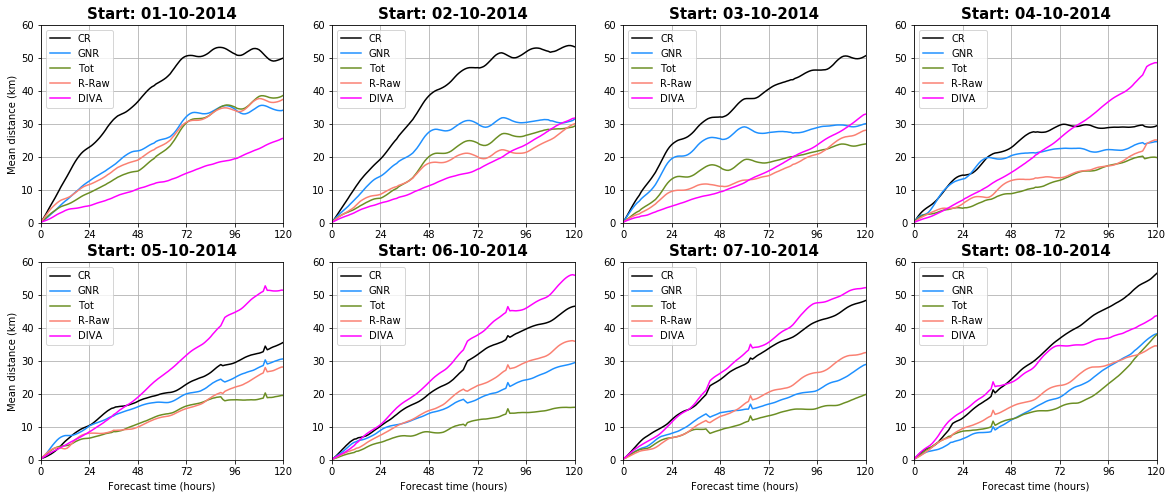

In [13]:
fig = plt.figure(figsize=(20,8))

date = datetime(2014,10,1)

for i in range(8):
    
    plt.subplot(2,4,i+1)  
    
    for ii, exp in enumerate(exps):

        plt.plot(dist_mean[exp][:,i], color=colors[ii])
    
    plt.legend(labels)
    plt.ylim((0,60))
    plt.xlim((0,120))
    
    if i>3:
        
        plt.xlabel('Forecast time (hours)')
    if i==0 or i==4:
        plt.ylabel('Mean distance (km)')
    
    plt.title('Start: {0}'.format(date.strftime('%d-%m-%Y')), fontsize=15, fontweight='bold')
    plt.grid(True)
    plt.xticks(ticks=[0,24,48,72, 96, 120])
    
    date = date + timedelta(days=1)
    
plt.show()

### Plot mean distance

In [29]:
subset = [0,1,3,5,7,9]
subset = [0,1,3,5,11]

#subset = [0,1,3,4,5,6]
subset = [0,2,4,6]# GNR, Tot, R-Raw
#subset = [0,2,4,6,8,10]
exps, colors, labels = select_experiments(subset, experiment_list=experiment_list)
labels

 Selected experiments: ['CR', 'GNR-N', 'Tot-N', 'R-Raw-N']


['CR', 'GNR-N', 'TOT-N', 'RAD-N']

In [30]:
set_font_size(16, 'bold')

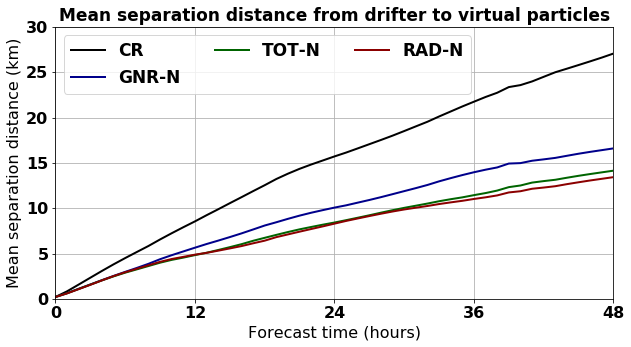

In [31]:

fig = plt.figure(figsize=(10,5))

for ii, exp in enumerate(exps):

    plt.plot( np.nanmean(np.nanmean(dist_all[exp], axis=0), axis=1), color=colors[ii], linewidth=2)

plt.legend(labels, fancybox=True, fontsize=17,ncol=3, loc='upper left')
plt.ylim((0,30))
plt.xlim((0,48))

plt.xlabel('Forecast time (hours)')
plt.ylabel('Mean separation distance (km)')

plt.title('Mean separation distance from drifter to virtual particles', fontsize=17, fontweight='bold')
plt.grid(True)
plt.xticks(ticks=[0,12,24,36,48])

plt.show()

In [21]:
mean_distance = np.empty((len(exps), 3))
for ii, exp in enumerate(exps):
    m_dist = np.nanmean(np.nanmean(dist_all[exp], axis=0), axis=1)
    mean_distance[ii,:] = [ m_dist[24], m_dist[48], m_dist[72]]
    
df_mean_dist = pd.DataFrame( data=mean_distance ,  columns= ['24 h', '48 h', '72h'], index=exps)
df_mean_dist

24 h       48 h        72h
CR     15.713987  27.070423  36.646274
GNR    11.616609  18.944056  23.287929
Tot     7.655572  12.748941  17.922860
R-Raw   8.372809  14.367156  19.934167
DIVA    8.402137  17.261462  26.674869

In [201]:
13.354317/27.152911

0.49181898029275756

In [200]:
14.330298/ 27.152911

0.5277628612269234

In [32]:
fig.savefig(F'/home/jhernandez/public_html/OSE/Code_v8_results/mean_separation_distance_48hr_tot_gnr_nudging_EGU.png', dpi=250)

## Liu Metric

In [179]:
# Hour for which to make the metric
kd = 48
ss = {}

for exp in experiment_list:
    
    # matrix containing the cumulative sum of distances between drifter and virtual particles
    di_sum = np.cumsum(dist_all[exp][:,1:,:], axis=1)
    # matrix containing the cumulative sum of distance travelled by the particles
    l0 = np.cumsum(dl_drif[:,:,:], axis=1)

    # Liu metric value for specific time kd
    s = di_sum[:,kd,:] / np.cumsum(l0, axis=1)[:,kd,:]
    ss[exp] = 1-s/1
   

    #aa = ss[exp]
    #print(exp)
    #print(F" NUmber of negative values = {aa[aa<0].shape}")

### Check if Points within coverage area

In [180]:
import shapefile
from shapely.geometry import Point
from shapely.geometry import Polygon

# Get radar data
u_radar, v_radar, lon, lat = tools.get_Currents_HFR('20141001',1)

# Plot mask contour
cs = plt.contour(lon, lat, u_radar.mask, 0)
plt.close()

# Get points of the mask contour
lon_cont = [a[0] for a in cs.allsegs[0][0]]
lat_cont = [a[1] for a in cs.allsegs[0][0]]

# Create polygon with the contour points
points = [tuple(a) for a in cs.allsegs[0][0]]
coverage = Polygon(points)

# Create polygon for DIVA area
points_diva = [(lonmax_hfr, latmin_hfr), (lonmax_hfr, latmax_hfr), (lonmin_hfr, latmax_hfr),
               (lonmin_hfr, latmin_hfr), (lonmax_hfr, latmin_hfr)] 
coverage_diva = Polygon(points_diva)

# Create empty matrix. Value=1 in inside coverage area
point_in = np.empty_like(lon0)
point_in_diva = np.empty_like(lon0)

# Check if Drifter position is inside the coverage area for every lon and lat pairs
for i in range(lon0.shape[0]):
    for j in range(lon0.shape[1]):
        point_in[i,j] = coverage.contains(Point(lon0[i,j], lat0[i,j]))
        point_in_diva[i,j] = coverage_diva.contains(Point(lon0[i,j], lat0[i,j]))
        
point_diva = (point_in==0) & (point_in_diva==1)

# Get Skill for each area
ss0 = {}
ss_diva_compare = {}

for i, exp in enumerate(experiment_list):
    
    S = ss[exp].T
    #S[S<0] = 0
    ss0[exp] = [np.nanmean(S), np.nanmean(S[point_in==1]), np.nanmean(S[point_in==0]) ]
    ss_diva_compare[exp] = [np.nanmean(S[point_in==0]), np.nanmean(S[point_diva]) ]
    
    #print(F" NUmber of negative values = {S[S<0].shape}")

In [181]:
set_font_size(16)

In [182]:
subset = [0,1,2,3,4,5,6,11]
subset = [0,1,3,5,7,9,11]  # analysis
#subset = [0,2,4,6,8,10,11]
#subset = [0,1,2,3,4,5,6,7,8,9,10,11]
#subset = [0,1,3,5,7,9,11,12,13]
exp_list, colors, labels = select_experiments(subset, experiment_list=experiment_list)


 Selected experiments: ['CR', 'GNR', 'Tot', 'R-Raw', 'R-In', 'R-Rep', 'DIVA']


#### Barplot Skill Score (by Areas)

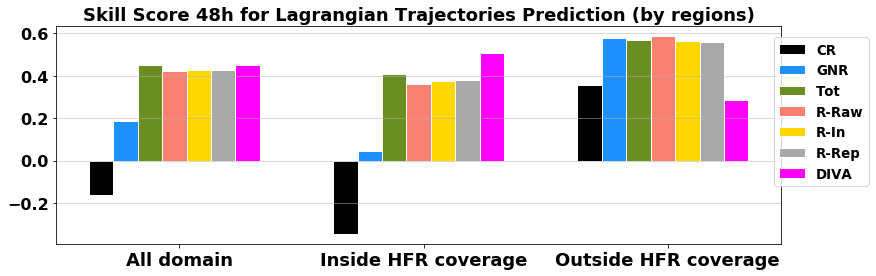

In [183]:
# set width of bar
##barWidth = 0.08
barWidth = 0.1

# Make the plot
fig = plt.figure(figsize=(13,4))

for i, exp in enumerate(exp_list):
    
    bars = ss0[exp]
    
    # Set position of bar on X axis
    if i==0:
        r1 = np.arange(len(bars))
    else:
        r2 = [x + barWidth for x in r1]
        r1 = r2
 

    plt.bar(r1, bars, color=colors[i], width=barWidth, edgecolor='white', label=labels[i])

# Add xticks on the middle of the group bars
#plt.ylabel('RMSD (m/s)', fontsize=13)#,fontweight='bold')
#plt.xticks([r + barWidth for r in range(len(bars1))], ['U', 'V'], fontsize=15)
plt.xticks([0.32, 1.32, 2.32], ['All domain', 'Inside HFR coverage', 'Outside HFR coverage'], fontsize=18)
    
# Create legend & Show graphic
plt.legend( fontsize='small',loc='upper right', bbox_to_anchor=(1.13, 0.98))
#plt.legend( fontsize='small',loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
plt.title(F'Skill Score {kd}h for Lagrangian Trajectories Prediction (by regions)', fontsize=18, fontweight='bold')
plt.grid('on', axis='y', linewidth=0.5)
plt.show()


In [118]:
fig.savefig(F'/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_diagrams/skill_score_diagrams_first8-days_{kd}hr_liu_analysis.png', dpi=250)

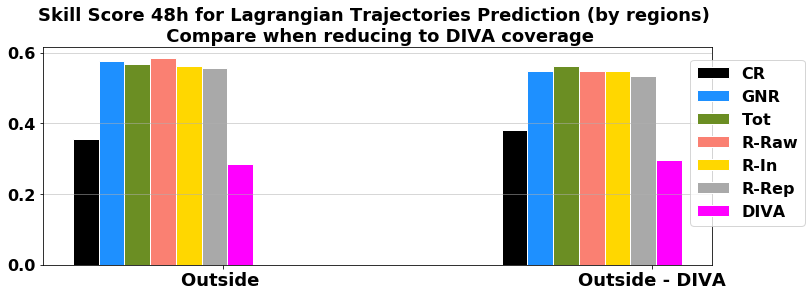

In [167]:
# set width of bar
##barWidth = 0.08
barWidth = 0.06

# Make the plot
fig = plt.figure(figsize=(12,4))

for i, exp in enumerate(exp_list):
    
    bars = ss_diva_compare[exp]
    
    # Set position of bar on X axis
    if i==0:
        r1 = np.arange(len(bars))
    else:
        r2 = [x + barWidth for x in r1]
        r1 = r2
 

    plt.bar(r1, bars, color=colors[i], width=barWidth, edgecolor='white', label=labels[i])

# Add xticks on the middle of the group bars
#plt.ylabel('RMSD (m/s)', fontsize=13)#,fontweight='bold')
#plt.xticks([r + barWidth for r in range(len(bars1))], ['U', 'V'], fontsize=15)
plt.xticks([0.32, 1.32], ['Outside ', 'Outside - DIVA'], fontsize=18)
    
# Create legend & Show graphic
plt.legend( fontsize='medium',loc='upper right', bbox_to_anchor=(1.15, 0.98))
plt.title(F'Skill Score {kd}h for Lagrangian Trajectories Prediction (by regions) \n Compare when reducing to DIVA coverage', fontsize=18, fontweight='bold')
plt.grid('on', axis='y', linewidth=0.5)
plt.show()


In [ ]:
#fig.savefig(F'/home/jhernandez/public_html/OSE/Code_v8_results/DIVA_evaluation_first8-days_{kd}hr_liu_skill_score_all_in-out_DIVA.png', dpi=250)

### Plot Map Skill Score

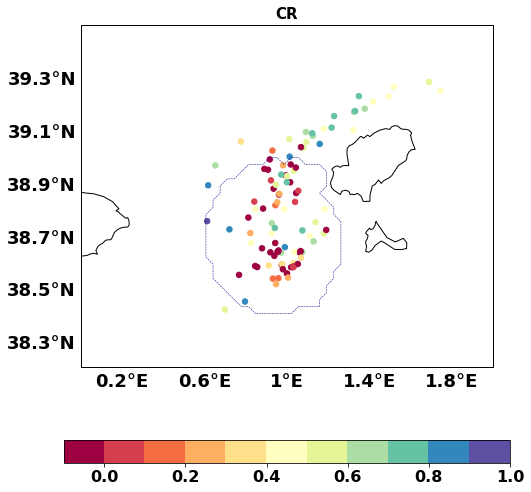

Skill Score = 0.2269117158494173


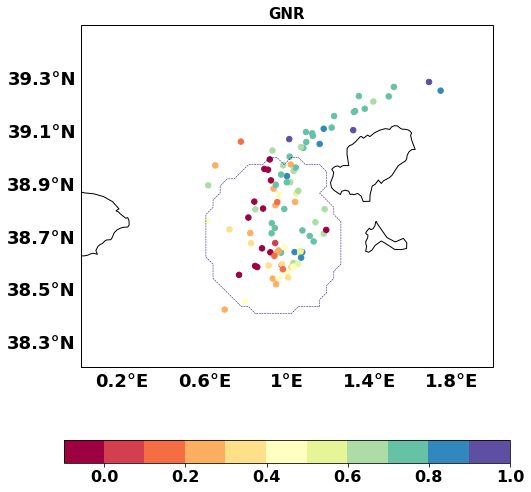

Skill Score = 0.457606871975856


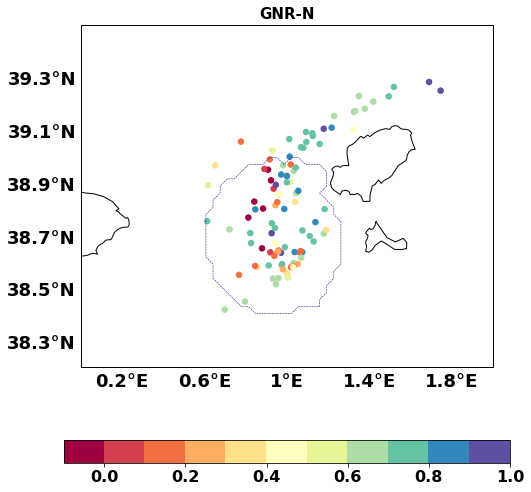

Skill Score = 0.519503398586297


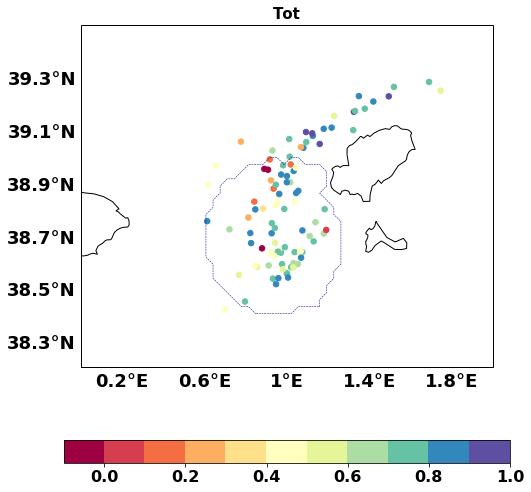

Skill Score = 0.6330742702031543


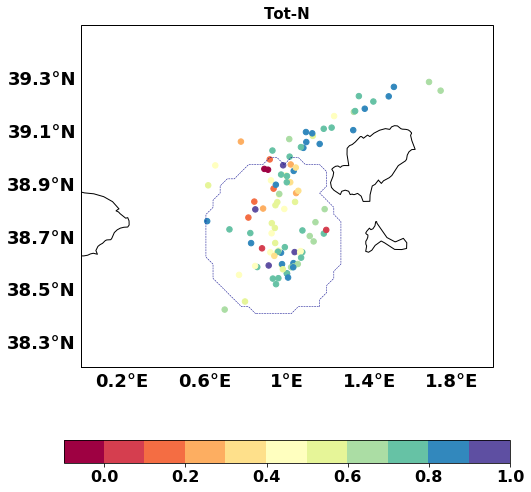

Skill Score = 0.6056381877288635


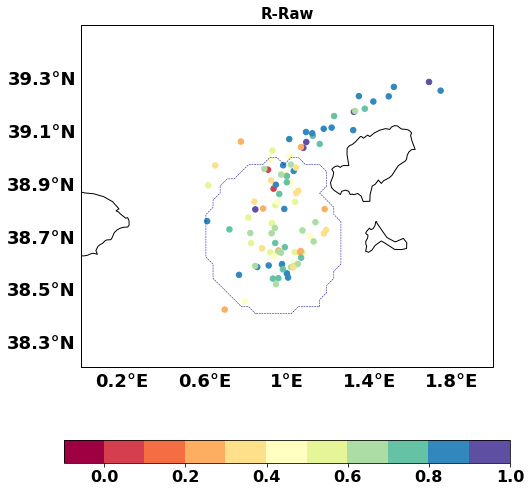

Skill Score = 0.6146140300076013


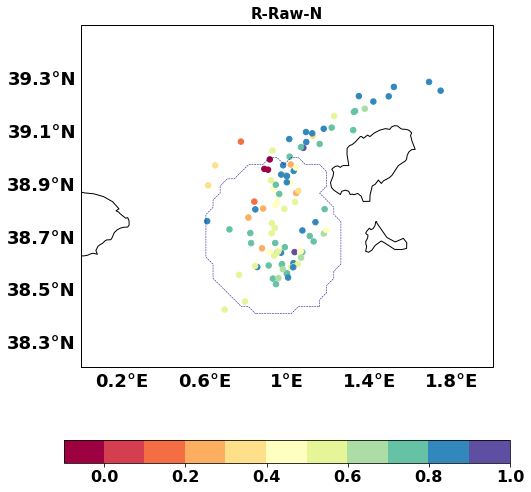

Skill Score = 0.6204203217146541


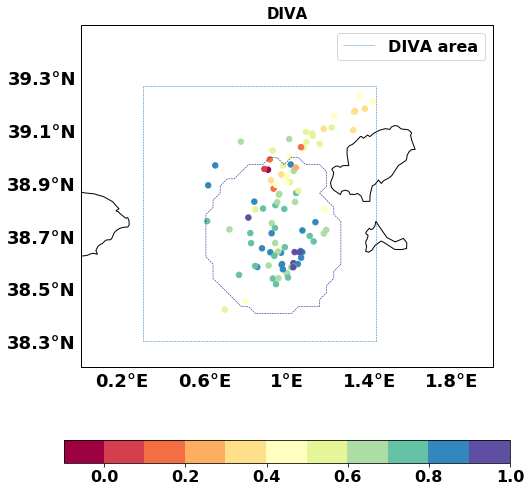

Skill Score = 0.6347057294528783


In [69]:
from pylab import *
import matplotlib.ticker as mticker

x = lon_cont
y = lat_cont

cmap = cm.get_cmap('Spectral',11)
for i, exp in enumerate(exp_list):

    fig = plt.figure(figsize=(8,9))

    ax, gl = tools.make_map(continents=False, limits=[0,2,38.2,39.5])
    if exp == 'DIVA':
        plt. scatter(lon0[point_in_diva==1], lat0[point_in_diva==1], 30, ss[exp].T[point_in_diva==1], transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
        plt.plot([lonmax_hfr, lonmax_hfr, lonmin_hfr, lonmin_hfr, lonmax_hfr], 
         [latmin_hfr, latmax_hfr, latmax_hfr, latmin_hfr, latmin_hfr],
         transform=gl.crs, linewidth=0.5, linestyle='--', label='DIVA area')
        plt.legend()
    else:
        plt. scatter(lon0, lat0, 30, ss[exp].T, transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
    plt.title(exp, fontsize=15, fontweight='bold')

    plt.colorbar(orientation='horizontal')
    
    plt.plot(x, y, 'darkblue', transform=gl.crs, linewidth=0.5, linestyle='--')
    
    gl.xlocator = mticker.FixedLocator([0.2, 0.6, 1.0, 1.4, 1.8])
    gl.ylocator = mticker.FixedLocator([38.3, 38.50, 38.7,38.9, 39.1, 39.3])
    
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}

    plt.show()
    
    print('Skill Score = ' + str(np.nanmean(ss[exp].T)) )
    
    #fig.savefig('/home/jhernandez/public_html/OSE/Seminario/Liu_metric/liu_metric_map_{0}_{1}.png'.format(kd, exp), dpi=250)
   # fig.savefig(F"/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_maps/liu_metric_map_{kd}h_{exp}.png", dpi=250)

### Check fields DIVA

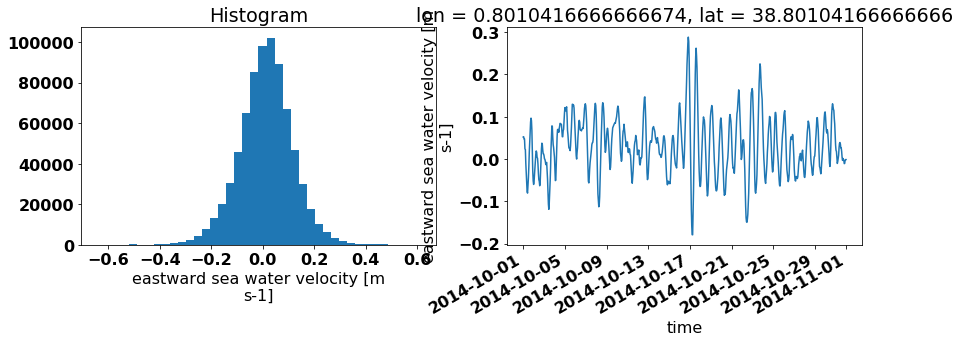

In [44]:
for var in ['u', 'v']:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    ds_hfr[var].plot(bins=40)
    plt.subplot(122)
    ds_hfr[var][:,15,15].plot()
    plt.show()
    


In [168]:
df_ss0 = pd.DataFrame.from_dict(ss0, orient='index', columns= ['SS total', 'SS In', 'SS Out'])
df_ss1 = pd.DataFrame.from_dict(ss_diva_compare, orient='index', columns= ['SS Out', 'SS In-DIVA'])
df_ss = df_ss0.reset_index().merge(df_ss1, how='left').set_index('index')

df_ss

SS total     SS In    SS Out  SS In-DIVA
index                                              
CR        -0.159632 -0.345285  0.356069    0.380175
GNR        0.186410  0.045556  0.577672    0.548076
GNR-N      0.279255  0.183980  0.543909    0.506217
Tot        0.449611  0.406576  0.569156    0.561863
Tot-N      0.408457  0.352843  0.562941    0.548674
R-Raw      0.421921  0.362869  0.585954    0.547874
R-Raw-N    0.430630  0.381140  0.568103    0.534028
R-In       0.425538  0.376405  0.562018    0.548414
R-In-N     0.431208  0.391491  0.541533    0.556017
R-Rep      0.425685  0.378130  0.557783    0.534787
R-Rep-N    0.399743  0.362298  0.503759    0.478448
DIVA       0.452059  0.505662  0.284549    0.295270
DIVA_Per   0.078565  0.054472  0.153856    0.158895
DIVA_mean  0.467153  0.516061  0.314318    0.326333

In [203]:
df_ss.loc[['CR', 'DIVA', 'GNR', 'Tot', 'R-Raw',  'GNR-N', 'Tot-N', 'R-Raw-N']][['SS total','SS In', 'SS Out']].round(2)

SS total  SS In  SS Out
index                           
CR          -0.16  -0.35    0.36
DIVA         0.45   0.51    0.28
GNR          0.19   0.05    0.58
Tot          0.45   0.41    0.57
R-Raw        0.42   0.36    0.59
GNR-N        0.28   0.18    0.54
Tot-N        0.41   0.35    0.56
R-Raw-N      0.43   0.38    0.57

In [47]:
df_ss['SS In'] / df_ss['SS In']['DIVA']

index
CR           0.293044
GNR          0.583278
GNR-N        0.727513
Tot          0.901883
Tot-N        0.864824
R-Raw        0.827801
R-Raw-N      0.928057
R-In         0.879776
R-In-N       0.918249
R-Rep        0.935955
R-Rep-N      0.877909
DIVA         1.000000
DIVA_Per     0.377902
DIVA_mean    1.054754
Name: SS In, dtype: float64

In [48]:
#df_ss.to_excel('/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_by_areas.xls')

In [189]:
experiment_list = {'CR': ['HFR_NOASSIM_Oct2014', 'black', 'CR'], 
                   'DIVA': ['DIVAnd-fields_v2', 'fuchsia', 'DIVA'],
            'GNR': ['HFR_generic_nonudging_Oct2014_v2', 'dodgerblue', 'GNR'],
            'GNR-N': ['HFR_generic_nudging_Oct2014_v2', 'darkblue', 'GNR-N'],
            'Tot': ['HFR_all_nonudging_Oct2014_v3', 'olivedrab', 'Tot'],
          #  'Tot2': ['HFR_totals_nonudging_Oct2014', 'green', 'Tot2'],
            'Tot-N': ['HFR_totals_nudging_Oct2014', 'darkgreen', 'Tot-N'],
            'R-Raw': ['HFR_radials_raw_nonudging_Oct2014', 'salmon', 'R-Raw'],     
            'R-Raw-N': ['HFR_radials_raw_nudging_Oct2014', 'darkred', 'R-Raw-N'],     
            'R-In': ['HFR_radials_inside_nonudging_Oct2014', 'gold', 'R-In'],
            'R-In-N': ['HFR_radials_inside_nudging_Oct2014', 'goldenrod', 'R-In-N'],
            'R-Rep': ['HFR_radials_rep_nonudging_Oct2014', 'darkgrey', 'R-Rep'],
            'R-Rep-N': ['HFR_radials_rep_nudging_Oct2014', 'grey', 'R-Rep-N'],
            
            
           }

subset = [0,1,2,4,6]
exp_list, colors, labels = select_experiments(subset, experiment_list=experiment_list)


 Selected experiments: ['CR', 'DIVA', 'GNR', 'Tot', 'R-Raw']


In [190]:
from pylab import *
import matplotlib.ticker as mticker

x = lon_cont
y = lat_cont


fig = plt.figure(figsize=(18,12))
cmap = cm.get_cmap('Spectral',11)

ks = [2,3,4,5,6]
for i, exp in enumerate(exp_list):
    
    ax, gl = tools.make_map(continents=True, subplot_dim=(2,3,ks[i]), limits=[0.5,1.85,38.29,39.35])
    if exp == 'DIVA':
        a = plt. scatter(lon0[point_in_diva==1], lat0[point_in_diva==1], 30, ss[exp].T[point_in_diva==1], transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
        plt.plot([lonmax_hfr, lonmax_hfr, lonmin_hfr, lonmin_hfr, lonmax_hfr], 
         [latmin_hfr, latmax_hfr, latmax_hfr, latmin_hfr, latmin_hfr],
         transform=gl.crs, linewidth=0.5, linestyle='--', label='DIVA area')
        plt.legend()
    else:
        a = plt. scatter(lon0, lat0, 30, ss[exp].T, transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
    plt.title(exp, fontsize=25, fontweight='bold')

    #plt.colorbar(orientation='horizontal')
    
    plt.plot(x, y, 'darkblue', transform=gl.crs, linewidth=0.5, linestyle='--')
    
    gl.xlocator = mticker.FixedLocator([0.6, 1.0, 1.4, 1.8])
    #gl.ylocator = mticker.FixedLocator([38.50, 38.7,38.9, 39.1, 39.3])
    gl.ylocator = mticker.FixedLocator([38.4, 38.6, 38.8, 39.0, 39.2])
    
    
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

    
    if i in [1,3,4,5,6]:
        gl.ylabels_left = False
    if i in [0,1]:
        gl.xlabels_bottom = False

    
    #plt.title(F"{experiments[i].replace('_',' ')} \n {strdate} ", fontweight='bold')
              
    
    #fig_raw_raw10.subplots_adjust(top=0.8)
    cbar_ax = fig.add_axes([0.20, 0.05, 0.60, 0.03])
    fig.colorbar(a, cax=cbar_ax, orientation='horizontal', extend='both')
    
plt.show()
    
#fig.savefig(F"/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_maps/liu_metric_map_{kd}h_{exp}.png", dpi=250)

In [191]:
fig.savefig(F"/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_maps/liu_metric_map_{kd}h_G-T-R.png", dpi=250)

In [130]:
subset = [0,1,2,4,6,8,10,12]
exp_list, colors, labels = select_experiments(subset, experiment_list=experiment_list)
set_font_size(20, 'normal')

 Selected experiments: ['CR', 'DIVA', 'GNR', 'Tot', 'R-Raw', 'R-In', 'R-Rep']


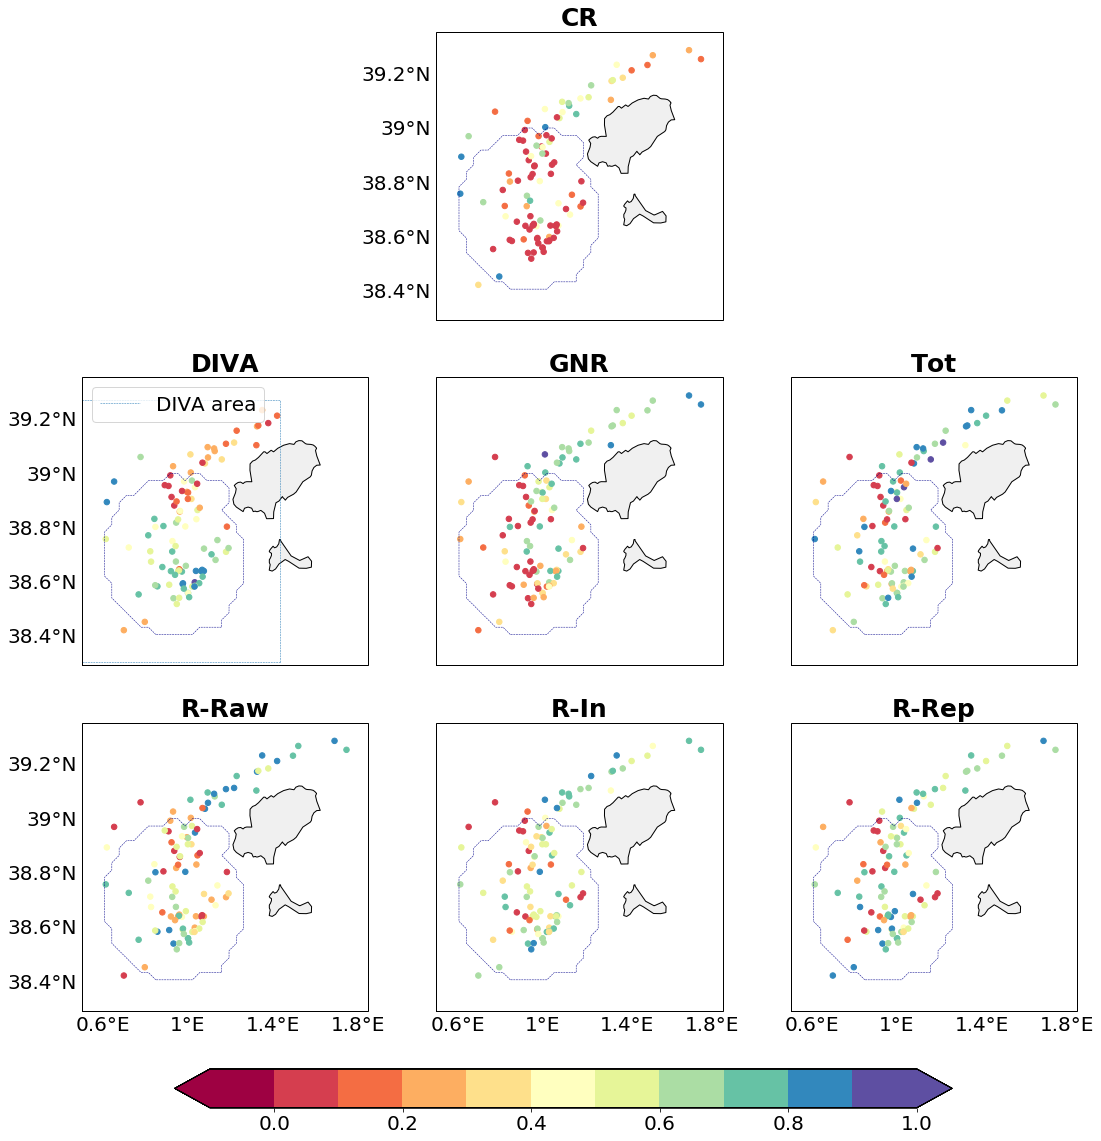

In [131]:
from pylab import *
import matplotlib.ticker as mticker

x = lon_cont
y = lat_cont


fig = plt.figure(figsize=(18,18))
cmap = cm.get_cmap('Spectral',11)

ks = [2,4,5,6,7,8,9]
for i, exp in enumerate(exp_list):
    
    ax, gl = tools.make_map(continents=True, subplot_dim=(3,3,ks[i]), limits=[0.5,1.85,38.29,39.35])
    if exp == 'DIVA':
        a = plt. scatter(lon0[point_in_diva==1], lat0[point_in_diva==1], 30, ss[exp].T[point_in_diva==1], transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
        plt.plot([lonmax_hfr, lonmax_hfr, lonmin_hfr, lonmin_hfr, lonmax_hfr], 
         [latmin_hfr, latmax_hfr, latmax_hfr, latmin_hfr, latmin_hfr],
         transform=gl.crs, linewidth=0.5, linestyle='--', label='DIVA area')
        plt.legend()
    else:
        a = plt. scatter(lon0, lat0, 30, ss[exp].T, transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
    plt.title(exp, fontsize=25, fontweight='bold')

    #plt.colorbar(orientation='horizontal')
    
    plt.plot(x, y, 'darkblue', transform=gl.crs, linewidth=0.5, linestyle='--')
    
    gl.xlocator = mticker.FixedLocator([0.6, 1.0, 1.4, 1.8])
    #gl.ylocator = mticker.FixedLocator([38.50, 38.7,38.9, 39.1, 39.3])
    gl.ylocator = mticker.FixedLocator([38.4, 38.6, 38.8, 39.0, 39.2])
    
    
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

    
    if i in [2,3,5,6,7,9,10,11]:
        gl.ylabels_left = False
    if i in [0,1,2,3]:
        gl.xlabels_bottom = False

    
    #plt.title(F"{experiments[i].replace('_',' ')} \n {strdate} ", fontweight='bold')
              
    
    #fig_raw_raw10.subplots_adjust(top=0.8)
    cbar_ax = fig.add_axes([0.20, 0.05, 0.60, 0.03])
    fig.colorbar(a, cax=cbar_ax, orientation='horizontal', extend='both')
    
plt.show()
    
#fig.savefig(F"/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_maps/liu_metric_map_{kd}h_{exp}.png", dpi=250)

In [132]:
fig.savefig(F"/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_maps/liu_metric_map_{kd}h_all.png", dpi=250)